<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/Seq_finetuning_YouTube_clickbait.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Check GPU, if assigned k8 then factory reset couple of times until we get Tesla GPU
!nvidia-smi

Mon Jul 19 07:48:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.3MB 8.1MB/s 
     |████████████████████████████████| 1.6MB 9.4MB/s 
     |████████████████████████████████| 645kB 41.5MB/s 
     |████████████████████████████████| 358kB 60.3MB/s 
     |████████████████████████████████| 102kB 14.6MB/s 
     |████████████████████████████████| 1.2MB 37.9MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 215kB 53.5MB/s 
     |████████████████████████████████| 37.2MB 74kB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 686kB 53.7MB/s 


#Imports

In [4]:
import os, math
import numpy as np
import pandas as pd
import requests
import shutil
import re
from pathlib import Path
import random
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score


import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization


from tensorflow import keras
from official.nlp import optimization  # to create AdamW optmizer
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

tf.get_logger().setLevel('ERROR')

import sys

#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')
from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [5]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


#Configs

##General config

In [92]:
tfrec_trainVal_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/train_val/'
tfrec_test_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/test/'
stop_clickbait_tfrecFiles_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/Stop_clickbait/tfrec_data/'

model_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/saved_models'
saved_model_name = f'youtube_clickbait_finetuned_SEQ'
saved_model_path = os.path.join(model_root_path, saved_model_name )

checkpoint_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints'
model_checkpoint_path = os.path.join(checkpoint_root_path, f'youtube_clickbait_finetuned_SEQ_checkpoint' )

MAX_LEN = 128
VOCAB_SIZE = 10000
BATCH_SIZE = 32  
# Label categories
label_list = [0,1]

init_lr = 2e-3

epochs = 10

#Scripts

In [71]:
#@title "Utilities [TF Dataset]"
def read_tfrecord(example):
    features = {
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string)  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    return text, class_num, label

def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.shuffle(num_train_examples)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.cache().prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  return dataset

In [72]:
#@title "Utilities [Create Model Definition]"
def create_model(encoder):
  inputs = keras.Input(shape=(None,), dtype="string")
  x = encoder(inputs)
  x = layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=128, mask_zero=True)(x)
  x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
  x = layers.Bidirectional(layers.LSTM(32))(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(1, activation='sigmoid', name='classifier' )(x)
  model = keras.Model(inputs, outputs)
  return model

In [73]:
#@title "Utilities [Model prediction]"
def get_metrics(y_test, y_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    print('F1 score: %f' % f1)
    # ROC AUC
    auc = roc_auc_score(y_test, y_pred)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    print(matrix)

def predict_on_test_dataset(model, test_data, BATCH_SIZE=32):
  y_true=[]
  
  for text_feat, labels in test_data:
    for i in range(BATCH_SIZE):
      y_true.append(labels[i].numpy())


  predicted_scores  = model.predict(test_data)
  y_pred = (predicted_scores > 0.5).astype("int32")
  y_pred = y_pred.reshape(-1)
  get_metrics(y_true, y_pred)
  vh.plot_cm(y_true, predicted_scores)
  print()

In [74]:
#@title "Utilities [Visualization]"
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

#Read TFRecord data

In [75]:
#@title  "Load files & Split"
#instantiate read_data utility
read_YouTube_data = read_tfrec_data(tfrec_trainVal_files_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

read_stop_clickbait_data = read_tfrec_data(stop_clickbait_tfrecFiles_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

# splitting data files between training, validation and test
YouTube_filenames, YouTube_training_filenames, YouTube_validation_filenames, YouTube_testing_filenames = read_YouTube_data.get_tfrec_files()

stop_clickbait_filenames, stop_clickbait_training_filenames,stop_clickbait_validation_filenames, stop_clickbait_testing_filenames = read_stop_clickbait_data.get_tfrec_files()

filenames = YouTube_filenames + stop_clickbait_filenames
training_filenames = YouTube_training_filenames + stop_clickbait_training_filenames
validation_filenames = YouTube_validation_filenames + stop_clickbait_validation_filenames

random.shuffle(filenames)
random.shuffle(training_filenames)
random.shuffle(validation_filenames)

#len(filenames), len(training_filenames), len(validation_filenames)

num_train_examples = 974 * len(YouTube_training_filenames) + 500 * len(stop_clickbait_training_filenames)
num_total_examples = 974 * len(YouTube_filenames) + 500 * len(stop_clickbait_filenames)

validation_steps = int(num_total_examples  // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(num_total_examples  // len(filenames) * len(training_filenames)) // BATCH_SIZE

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))



Pattern matches 14 data files. Splitting dataset into 12 training files , 2 validation files and 0 test files
Pattern matches 64 data files. Splitting dataset into 52 training files , 12 validation files and 0 test files
With a batch size of 32, there will be 1170 batches per training epoch and 255 batch(es) per validation run.


In [76]:
#instantiate read_data utility for test set
read_test_data = read_tfrec_data(tfrec_test_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=1)

# splitting data files between training, validation and test
testing_filenames, _, _,_ = read_test_data.get_tfrec_files()
len(testing_filenames)

Pattern matches 2 data files. Splitting dataset into 2 training files , 0 validation files and 0 test files


2

#Load TFRecord into TF Dataset

In [77]:
# create the datasets
with tf.device('/cpu:0'):
  train_ds = load_dataset(training_filenames)
  val_ds = load_dataset(validation_filenames)
  test_ds = load_dataset(testing_filenames)

In [78]:
for i,(text, class_num, label) in enumerate(train_ds.take(10)):
  print(f"text : {text.numpy()}, class : {class_num.numpy()}, label : {label.numpy()}")

text : b'movies in minutes final destination trailer spoof of the next final destination special thanks to dtrix district link for the beat used in this video check out my nd channel twitter facebook website also thanks for the cameos ytf victor king kevjumba', class : 0, label : b'nonclickbaits'
text : b'repo prank come join me on facebook instagram and instagram romanatwood song available here even for us this was a awkward video to make but a lot of fun join us on fb prankster dennis roady', class : 1, label : b'clickbaits'
text : b'world s hardest prop hunt ever garry s mod let s go for likes subscribe for more videos check out more videos over here q a series challenge series check out my friends jelly slogoman on my channel i play a bunch of amazing games such as happy wheels gta and minecraft check out my socialmedia twitter instagram facebook outro song can t stop won t stop mighty high download on itunes intro song nu disco televisor neon monstercat release', class : 1, label 

In [79]:
with tf.device('/cpu:0'):
  train_ds = train_ds.map(lambda text, class_num, label:(text, class_num))
  val_ds = val_ds.map(lambda text, class_num, label:(text, class_num))
  test_ds = test_ds.map(lambda text, class_num, label:(text, class_num))

In [80]:
# Create text encoder and adapt it on train dataset
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, output_sequence_length=MAX_LEN)
encoder.adapt(train_ds.map(lambda text, label: text))

In [81]:
#Let's see the first 20 vocabulary
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'and', 'a', 'of', 'on', 'you', 'in',
       'for', 'my', 's', 'twitter', 'is', 'i', 'follow', 'that', 'this',
       'instagram'], dtype='<U24')

In [82]:
with tf.device('/cpu:0'):
  train_ds = get_batched_dataset(train_ds, train=True)
  val_ds = get_batched_dataset(val_ds)
  test_ds = get_batched_dataset(test_ds)

#Modeling

In [93]:
# train data spec
train_ds.element_spec

(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

##Build classifier

In [94]:
classifier_model = create_model_new(encoder)
classifier_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 128)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 128, 128)          1280000   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 128, 128)          98816     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 64)                41216     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160

##Train classifier model

###Compile model

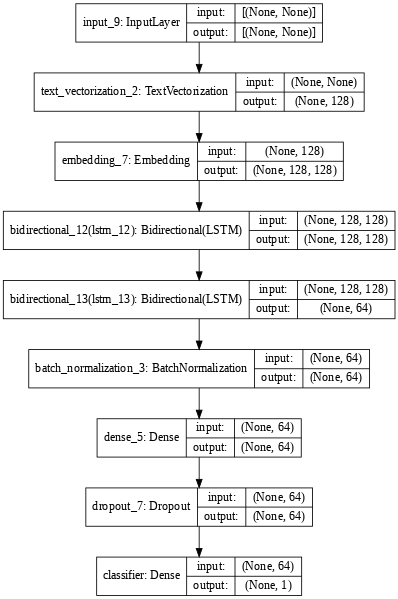

In [95]:
es = tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', 
          verbose=1, 
          patience=5, 
          mode='min', 
          restore_best_weights=True
          )

mcb = tf.keras.callbacks.ModelCheckpoint (
         filepath=model_checkpoint_path,
         save_weights_only=True,
         monitor='val_prc',
         mode='max',
         verbose=1,
         save_best_only=True
        )

METRICS = [
             keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn'), 
             keras.metrics.BinaryAccuracy(name='accuracy'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc'),
             keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw'
      )

classifier_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
    )

tf.keras.utils.plot_model(model=classifier_model, show_shapes=True, dpi=60)

In [96]:
#@title Load weights if available
if os.path.exists(model_checkpoint_path):
  print('loading saved weight')
  classifier_model.load_weights(model_checkpoint_path)
else:
  print('No weight to initialize')

No weight to initialize


###Train

In [97]:
history = classifier_model.fit(
             x=train_ds,
             validation_data=val_ds,
             epochs=epochs,
             validation_steps=100,
             callbacks=[es, mcb]
             )

Epoch 1/10
1176/1176 [==============================] - 83s 58ms/step - loss: 0.1830 - tp: 17083.0000 - fp: 1483.0000 - tn: 17758.0000 - fn: 1308.0000 - accuracy: 0.9258 - precision: 0.9201 - recall: 0.9289 - auc: 0.9795 - prc: 0.9786 - val_loss: 0.0855 - val_tp: 1429.0000 - val_fp: 26.0000 - val_tn: 1683.0000 - val_fn: 62.0000 - val_accuracy: 0.9725 - val_precision: 0.9821 - val_recall: 0.9584 - val_auc: 0.9941 - val_prc: 0.9934

Epoch 00001: val_prc improved from -inf to 0.99339, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_finetuned_SEQ_checkpoint
Epoch 2/10
1176/1176 [==============================] - 64s 54ms/step - loss: 0.0554 - tp: 18041.0000 - fp: 384.0000 - tn: 18857.0000 - fn: 350.0000 - accuracy: 0.9805 - precision: 0.9792 - recall: 0.9810 - auc: 0.9973 - prc: 0.9968 - val_loss: 0.0824 - val_tp: 1451.0000 - val_fp: 45.0000 - val_tn: 1664.0000 - val_fn: 40.0000 - val_accuracy: 0.9734 - val_

In [98]:
# Save model weights
classifier_model.save_weights(model_checkpoint_path)

#Plot train history

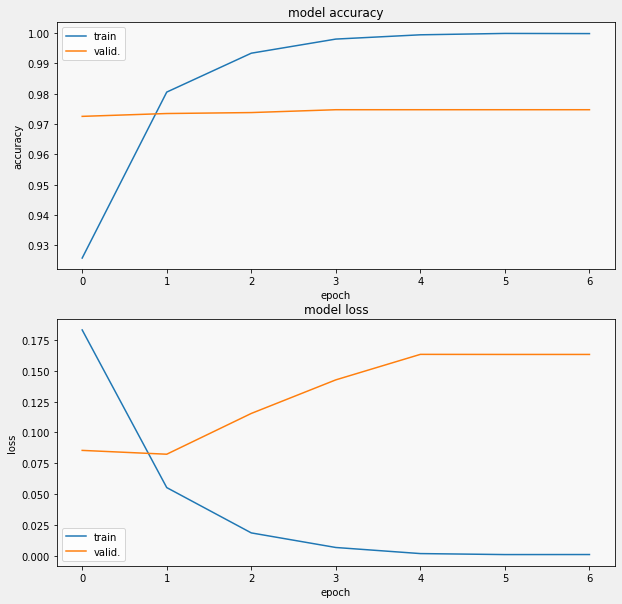

In [99]:
vh.display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

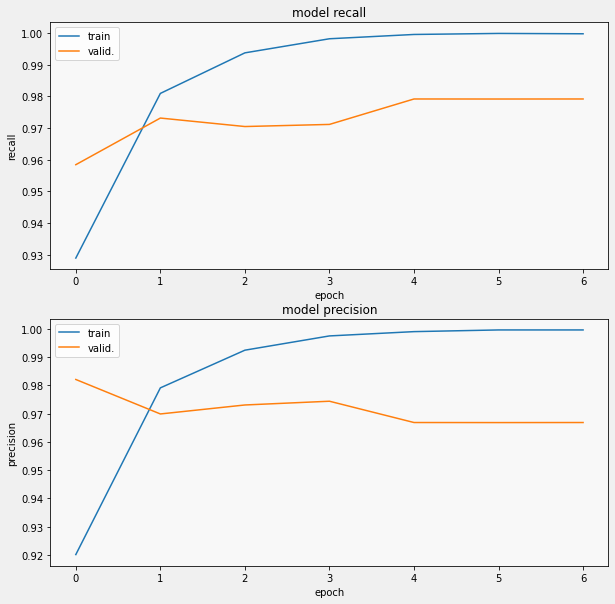

In [100]:
vh.display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
vh.display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

#Evaluate model

In [101]:
results = classifier_model.evaluate(test_ds)

for name, value in zip(classifier_model.metrics_names, results):
  print(name, ': ', value)
print()

60/60 [==============================] - 2s 28ms/step - loss: 0.0779 - tp: 875.0000 - fp: 19.0000 - tn: 1004.0000 - fn: 22.0000 - accuracy: 0.9786 - precision: 0.9787 - recall: 0.9755 - auc: 0.9940 - prc: 0.9929
loss :  0.07792922109365463
tp :  875.0
fp :  19.0
tn :  1004.0
fn :  22.0
accuracy :  0.9786458611488342
precision :  0.9787471890449524
recall :  0.9754738211631775
auc :  0.9939873218536377
prc :  0.9929027557373047



#Export for inference

In [102]:
classifier_model.save(saved_model_path, include_optimizer=False)

#Model prediction

In [103]:
saved_classifier = keras.models.load_model(saved_model_path)

Accuracy: 0.978646
Precision: 0.978747
Recall: 0.975474
F1 score: 0.977108
ROC AUC: 0.978450
[[1004   19]
 [  22  875]]
Non clickbaits Detected (True Negatives):  1004
Non-Clickbaits Detected as Clickbaits (False Positives):  19
Clickbaits Detected as Non-clickbaits (False Negatives):  22
Clickbaits Detected (True Positives):  875
Total Non-clickbaits:  1023
Total Clickbaits:  897



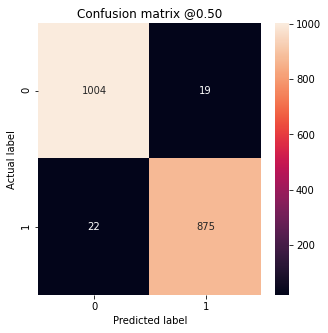

In [104]:
predict_on_test_dataset(saved_classifier, test_ds, BATCH_SIZE=BATCH_SIZE)